In [ ]:
!nvidia-smi

Sun Feb 28 17:36:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet

import os

Se va introduce calea fisierelor care contin fotografiile pentru antrenare si testare ale fiecarei clase

In [ ]:
# test and train file paths
classes = ['bed', 'cake', 'chair', 'human', 'pizza', 'salad', 'sandwich', 'sofa', 'soup', 'spaghetti', 'steak', 'table'] #alphabetical order
train_path = '/content/drive/MyDrive/Colab Projects/food_nofood_dataset_classification/train/'
test_path = '/content/drive/MyDrive/Colab Projects/food_nofood_dataset_classification/test/'
bed = glob.glob(train_path + classes[0]+'/*')
cake = glob.glob(train_path + classes[1]+'/*')
chair = glob.glob(train_path + classes[2]+'/*')
human = glob.glob(train_path + classes[3]+'/*')
pizza = glob.glob(train_path + classes[4]+'/*')
salad = glob.glob(train_path + classes[5]+'/*')
sandwich = glob.glob(train_path + classes[6]+'/*')
sofa = glob.glob(train_path + classes[7]+'/*')
soup = glob.glob(train_path + classes[8]+'/*')
spaghetti = glob.glob(train_path + classes[9]+'/*')
steak = glob.glob(train_path + classes[10]+'/*')
table = glob.glob(train_path + classes[11]+'/*')
train_classes = [bed,cake,chair,human,pizza,salad,sandwich,sofa,soup,spaghetti,steak,table]
train_total = 0
for i in train_classes:
  train_total += len(i)

bed_test = glob.glob(test_path + classes[0]+'/*')
cake_test = glob.glob(test_path + classes[1]+'/*')
chair_test = glob.glob(test_path + classes[2]+'/*')
human_test = glob.glob(test_path + classes[3]+'/*')
pizza_test = glob.glob(test_path + classes[4]+'/*')
salad_test = glob.glob(test_path + classes[5]+'/*')
sandwich_test = glob.glob(test_path + classes[6]+'/*')
sofa_test = glob.glob(test_path + classes[7]+'/*')
soup_test = glob.glob(test_path + classes[8]+'/*')
spaghetti_test = glob.glob(test_path + classes[9]+'/*')
steak_test = glob.glob(test_path + classes[10]+'/*')
table_test = glob.glob(test_path + classes[11]+'/*')
test_classes = [bed_test,cake_test,chair_test,human_test,pizza_test,salad_test,sandwich_test,sofa_test,soup_test,spaghetti_test,steak_test,table_test]
test_total = 0
for i in test_classes:
  test_total += len(i)

# total train and test images for each category
print('Number of images per class:\nclass\t\ttrain\ttest')
for i in range(len(classes)):
  if len(classes[i])<=5:
    print('{}:\t\t{}\t{}\n'.format(classes[i],len(train_classes[i]),len(test_classes[i])))
  else:
    print('{}:\t{}\t{}\n'.format(classes[i],len(train_classes[i]),len(test_classes[i])))
print('Total:\t\t{}\t{}'.format(train_total,test_total))

Number of images per class:
class		train	test
bed:		200	50

cake:		200	50

chair:		200	50

human:		200	50

pizza:		200	50

salad:		200	50

sandwich:	200	50

sofa:		200	50

soup:		200	50

spaghetti:	200	50

steak:		200	50

table:		200	50

Total:		2400	600


Previzualizarea imaginilor inainte de procesarea specifica pentru antrenarea modelului MobileNet si analizarea setului de date.

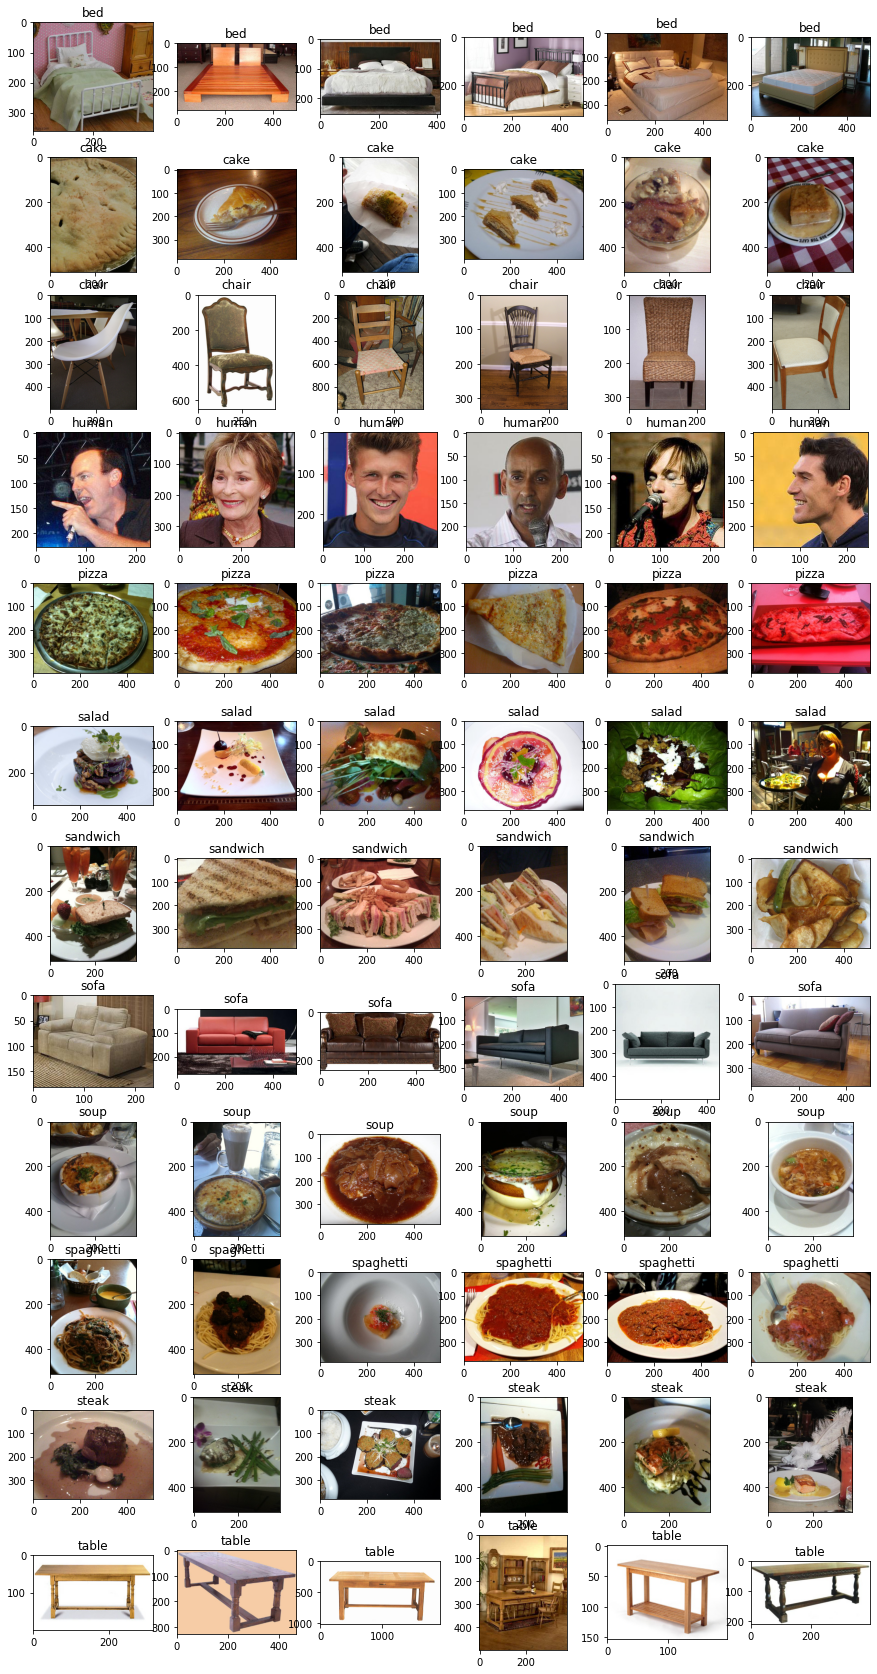

In [ ]:
# preview 6 images of each class
classes = ['bed', 'cake', 'chair', 'human', 'pizza', 'salad', 'sandwich', 'sofa', 'soup', 'spaghetti', 'steak', 'table'] 
train_classes = [bed,cake,chair,human,pizza,salad,sandwich,sofa,soup,spaghetti,steak,table]
nr = 6
# seed the pseudorandom number generator
from random import randint

classes_number = len(classes)
fig, axes = plt.subplots(classes_number,nr,figsize=(15,30))

for i in range(classes_number):
  for j in range(nr):
    axes[i, j].imshow(plt.imread(train_classes[i][j*10]))#show every 10th picture
    axes[i, j].set_title(classes[i])

Se poate observa ca fotografiile sunt diferite din punct de vedere al calitatii lor. Astfel, unele imagini sunt suprinse in lumina nefavorabila, si au dimensiuni, fundaluri si zgomot de imagine cu intensitati diferite.

## **Data Augmentation**

Marirea datelor formate din imagini reprezinta o tehnica folosita in invatarea profunda pentru a extinde in mod artificial setul de date folosit pentru antrenarea modelului. Prin aceasta tehnica sunt create versiuni (copii) ale imaginilor originale, dar cu mici modificari, fiind afectate de diferiti factori. 

Datorita acestui proces se obtine o crestere a performantei modelului si a abilitatii sale de a generaliza. Astfel, se evita memorarea imaginilor si sunt invatate tipare.

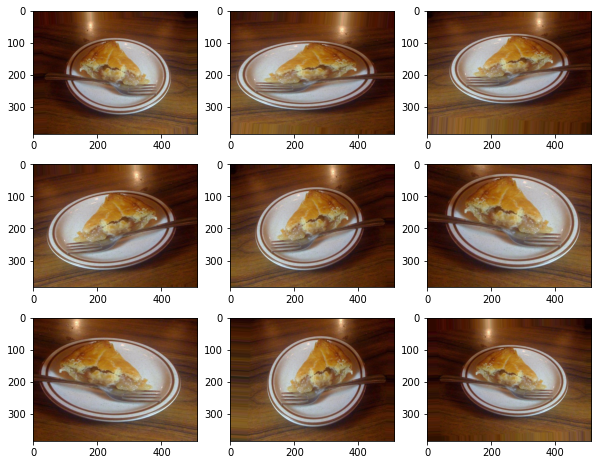

In [ ]:
# example of one image after image augmentation
# load the image
img = load_img(cake[10])
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(img, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
                 width_shift_range=0.05, #randomly shift images horizontally (percentage of total width)
                 height_shift_range=0.05, ##randomly shift images vertically (percentage of total height)
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True, #flip images horizontally but not vertically because food can't stay upside down on the plate or table.
                 vertical_flip=False)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
fig, axes = plt.subplots(3,3,figsize=(10,8))
for i in range(3):
  for j in range(3):
    # define subplot
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    axes[i,j].imshow(image)
# show the figure
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
                 width_shift_range=0.05, #randomly shift images horizontally (percentage of total width)
                 height_shift_range=0.05, ##randomly shift images vertically (percentage of total height)
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True, #flip images horizontally but not vertically because food can't stay upside down on the plate or table and video is vertical so every object is gonna stay as first person view.
                 vertical_flip=False,
                 rescale=1/255) #normalize image, add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory( #images are loaded progressively in alphabetical order and assigned an integer for each class 
        train_path,
        target_size=(224,224),
        batch_size=16)
test_datagen = ImageDataGenerator(rescale=1/255) # just normalize for testing set
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=16)

Found 2400 images belonging to 12 classes.
Found 600 images belonging to 12 classes.


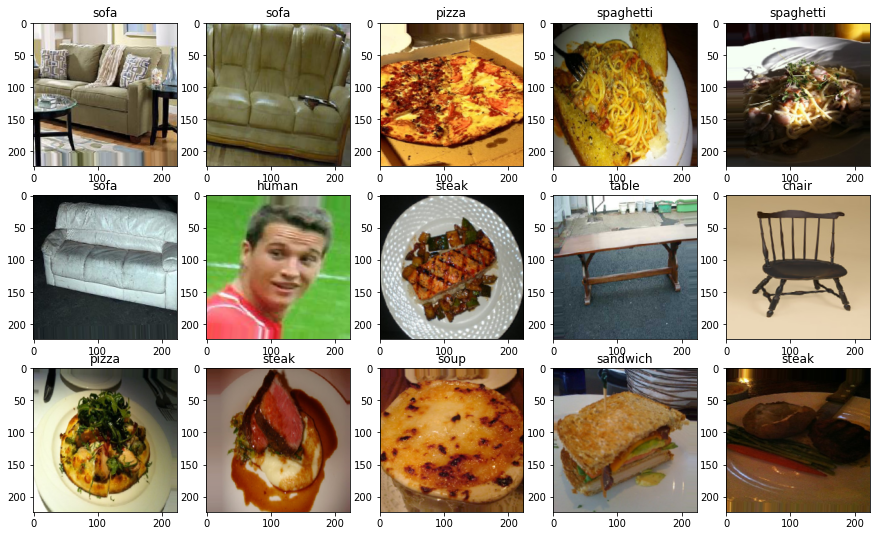

In [ ]:
# preview images from train generator
r = 3; c = 5
n=0
classtolabel = {'0':'bed','1':'cake','2':'chair', '3':'human', '4':'pizza', '5':'salad', '6':'sandwich', '7':'sofa', '8':'soup', '9':'spaghetti', '10':'steak', '11':'table'} #alphabetical order, each class assigned an integer because of flow_from_directory() function
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(15,9))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

## **Modelare**

Antrenarea modelului va fi facuta prin tehnica transfer learning. Astfel, setul de date si durata necesara pentru antrenare pot fi mai mici. Modelul de baza peste care se aplica noile cunostinte este modelul Keras MobileNet



In [ ]:
nclass = len(train_generator.class_indices)
base_model = MobileNet(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
base_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

Diluarea (Dropout) este o tehnică de regularizare pentru reducerea supraîncadrării(overfitting) în rețelele neuronale artificiale prin prevenirea memorizarii datelor de antrenament. In arhitectura modelului antrenat voi renunta la 20% din datele de antrenare.

Stratul de iesire are 12 neuroni deoarece sunt 12 clase folosite pentru clasificarea imaginilor.

In [ ]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dropout(0.2),#dropout 20% of data to avoid memorization 
  Dense(nclass, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2())])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                12300     
Total params: 3,241,164
Trainable params: 12,300
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
#callbacks
checkpointer = ModelCheckpoint(filepath='modelMobileNet12Classes.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

Antrenare pentru 100 epoci.

In [ ]:
batch_size = 16
history = model.fit(train_generator,steps_per_epoch=train_total/batch_size,
                              validation_data=test_generator,validation_steps=test_total/batch_size, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping])

Epoch 1/100
150/150 [==============================] - 697s 5s/step - loss: 1.3329 - accuracy: 0.6300 - val_loss: 0.7355 - val_accuracy: 0.8233

Epoch 00001: val_loss improved from inf to 0.73546, saving model to modelMobileNet12Classes.hdf5
Epoch 2/100
150/150 [==============================] - 36s 239ms/step - loss: 0.7534 - accuracy: 0.8233 - val_loss: 0.6369 - val_accuracy: 0.8600

Epoch 00002: val_loss improved from 0.73546 to 0.63692, saving model to modelMobileNet12Classes.hdf5
Epoch 3/100
150/150 [==============================] - 36s 238ms/step - loss: 0.6445 - accuracy: 0.8496 - val_loss: 0.5933 - val_accuracy: 0.8567

Epoch 00003: val_loss improved from 0.63692 to 0.59331, saving model to modelMobileNet12Classes.hdf5
Epoch 4/100
150/150 [==============================] - 36s 242ms/step - loss: 0.5510 - accuracy: 0.8804 - val_loss: 0.5370 - val_accuracy: 0.8683

Epoch 00004: val_loss improved from 0.59331 to 0.53696, saving model to modelMobileNet12Classes.hdf5
Epoch 5/100
15

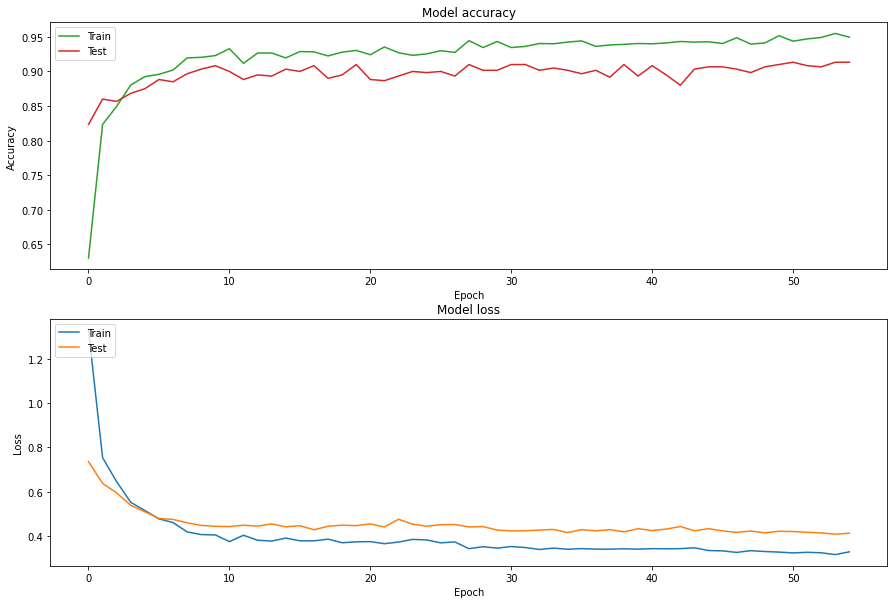

In [ ]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

## **Evaluarea rezultatelor**

In [ ]:
# create another generator for all test images in a single batch
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=test_total)

Found 600 images belonging to 12 classes.


**Predictii**

Incarcarea modelului salvat

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model12classes-MobileNet.h5"
model = load_model(export_path_keras)

Procentul de acuratete al modelului antrenat: 91,3%

In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 91.3%


Verificarea a 10 predictii la intamplare

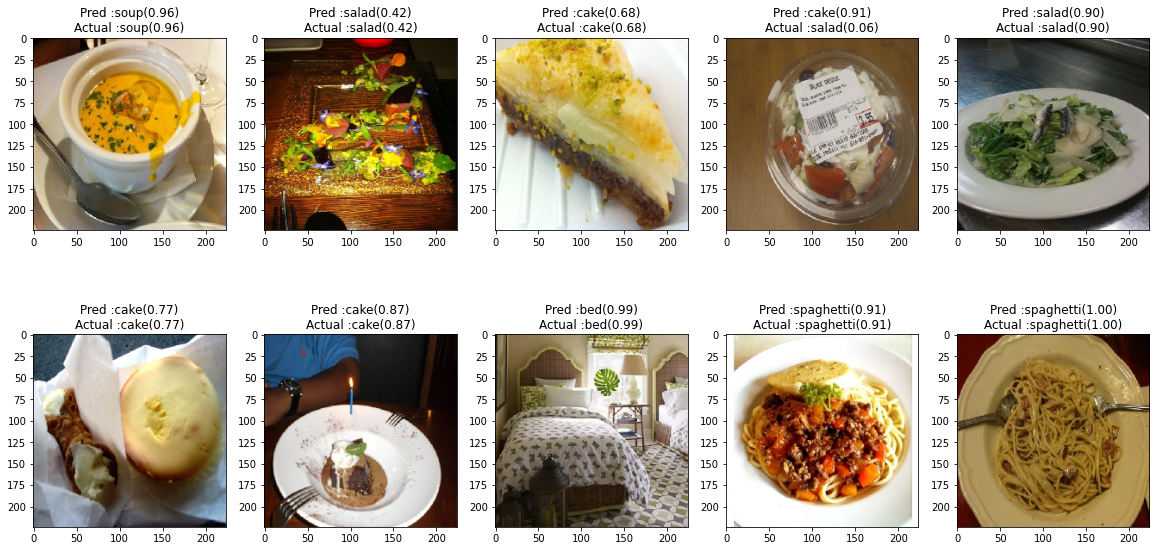

In [ ]:
f, ax=plt.subplots(2,5,figsize=(20,10))
for k in range(2):
  for l in range(5):
      j=np.random.randint(1,len(x_test))
      ax[k,l].imshow(x_test[j])
      ax[k,l].set_title("Pred :{}({:.2f})\nActual :{}({:.2f})".format
                            (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                            classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))

**Matricea confuziilor**

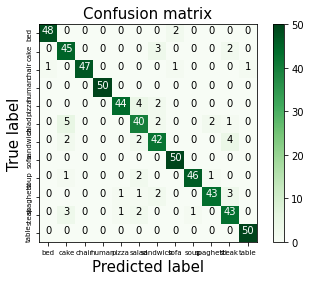

In [ ]:
def plot_confusion_matrix(cm):    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['bed', 'cake', 'chair', 'human', 'pizza', 'salad', 'sandwich', 'sofa', 'soup', 'spaghetti', 'steak', 'table'] 
    plt.xticks([i for i in range(len(classes))], classes, fontsize=7)
    plt.yticks([i for i in range(len(classes))], classes, fontsize=7,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

In urma analizarii matricei confuziilor, modelul nu a prezis mancarea ca nefiind mancare. Astfel s-a obtinut o acuratete de 100% de identificare a mancarii sau a imaginilor care nu contin mancare.

Verificarea predictiilor eronate (cu cea mai mare diferenta intre eticheta prezisa si cea adevarata)

In [ ]:
# find the wrongest label (largest confidence wrong label)
def show_wrong_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 4
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nActual :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

In [ ]:
show_wrong_label(x_test,y_test,y_pred_conf)

Output hidden; open in https://colab.research.google.com to view.

Se poate observa ca in prezicerile eronate, modelul nu a incurcat mancarea cu obiectele din imaginile care nu contin mancare. De asemenea setul de date a continut si imagini clasificate eronat(clasa pizza dar imaginea nu contine pizza), precum prima imagine de pe a 2-a linie.

## **Salvarea modelului**

Voi salva modelul sub formatul de fisier HDF5 specific Keras. Fisierul HDF5 va avea extensia .h5

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model12classes-MobileNet.h5"
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/Colab Projects/model12classes-MobileNet.h5


Incarcarea modelului salvat

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model12classes-MobileNet.h5"
reloaded = load_model(export_path_keras)

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                12300     
Total params: 3,241,164
Trainable params: 12,300
Non-trainable params: 3,228,864
_________________________________________________________________


## **Predictia unei singure imagini**

Imaginea va fi incarcata din Google Drive

array([[4.7752223e-05, 9.8957920e-05, 3.2128301e-03, 2.6331237e-04,
        1.7214401e-02, 8.7093776e-01, 2.9064473e-03, 3.0618804e-04,
        5.9091547e-03, 5.1715855e-02, 4.7028843e-02, 3.5845328e-04]],
      dtype=float32)

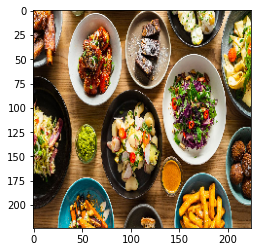

In [ ]:
img=load_img('/content/drive/MyDrive/Colab Projects/food_3classes100Photos/restaurant_hero_FCKbh.jpg',target_size=(224,224))
plt.imshow(img)
img = np.array(img).astype('float32')/255
img = np.expand_dims(img, axis=0)
reloaded.predict(img)

In [ ]:
classtolabel = {'0':'bed','1':'cake','2':'chair', '3':'human', '4':'pizza', '5':'salad', '6':'sandwich', '7':'sofa', '8':'soup', '9':'spaghetti', '10':'steak', '11':'table'}
result = reloaded.predict(img)
maximum = np.max(result)
y_pred = np.argmax(result,axis=1)
print(classtolabel[str(y_pred[0])])
#make a threshold such that, only if the model is at least 40% sure that the object is food, then food exists in the picture
#if maximum >= 0.4: #apply threshold of 40% 
#  print(classtolabel[str(y_pred[0])])
#else:
#  print('the model is not sure if there is even food in the picture')

salad
